##### SARIMA

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX  # <--- Tambahkan ini

In [46]:
# Membaca Dataset
df = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'])

In [47]:
# Mengurutkan datanya
df = df.sort_values('Datetime')
df.set_index('Datetime', inplace=True)

In [49]:
# Mengelompokkan data per hari berdasarkan jumlah konsumsi
df_daily = df.resample('D').sum()
print(df_daily.head())

              AEP_MW
Datetime            
2004-10-01  328544.0
2004-10-02  311997.0
2004-10-03  293450.0
2004-10-04  343417.0
2004-10-05  346553.0


In [50]:
print(df_daily.tail())

              AEP_MW
Datetime            
2018-07-30  368834.0
2018-07-31  364327.0
2018-08-01  363628.0
2018-08-02  376504.0
2018-08-03   14809.0


<Axes: xlabel='Datetime'>

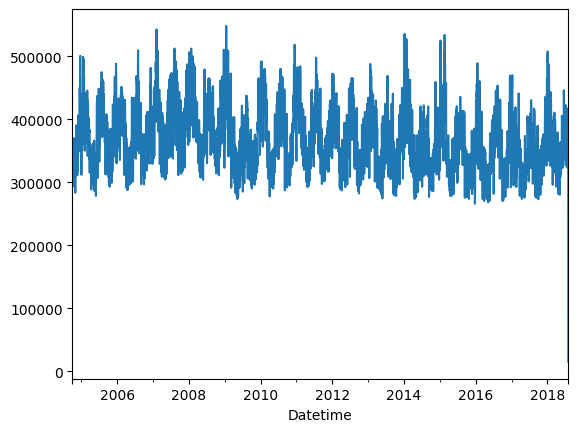

In [52]:
# Membuat Plot Pattern
df_daily['AEP_MW'].plot()

In [53]:
# Split train dan test
train = df_daily[df_daily.index < '2014-01-01']
test = df_daily[df_daily.index >= '2014-01-01']

In [54]:
# Tentukan parameter SARIMA manual (bisa disesuaikan dengan AIC pada percobaan lain)
# SARIMA(p,d,q)(P,D,Q,s) -> seasonal_order
# Di sini kita coba: SARIMA(1,1,1)(1,1,1,7) -> asumsi musiman mingguan

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            AEP_MW   No. Observations:                 3379
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -38047.583
Date:                           Thu, 19 Jun 2025   AIC                          76105.166
Time:                                   13:25:17   BIC                          76135.768
Sample:                               10-01-2004   HQIC                         76116.110
                                    - 12-31-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1983      0.092     -2.153      0.031      -0.379      -0.018
ma.L1          0.4259      0.083      5.104

In [55]:
# Prediksi sebanyak panjang test set
forecast = model_fit.forecast(steps=len(test))

# Hitung RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)


RMSE: 235633.31482204486


In [57]:
print(test.describe())


              AEP_MW
count    1676.000000
mean   357036.097852
std     47213.955901
min     14809.000000
25%    322385.500000
50%    350797.500000
75%    387704.750000
max    535660.000000


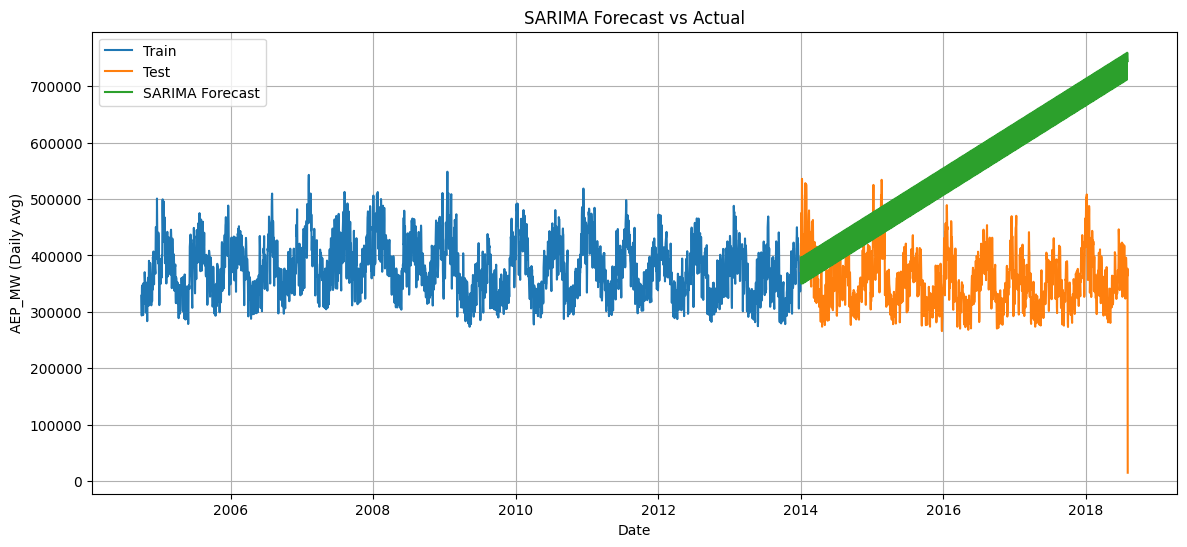

In [56]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='SARIMA Forecast')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AEP_MW (Daily Avg)')
plt.grid(True)
plt.show()


##### ARIMA

In [155]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [159]:
# Baca data
df = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'])
df = df.sort_values('Datetime')
df.set_index('Datetime', inplace=True)
df.head(n=10)

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
2004-10-01 06:00:00,12280.0
2004-10-01 07:00:00,13692.0
2004-10-01 08:00:00,14618.0
2004-10-01 09:00:00,14903.0


In [ ]:
# Mengelompokkan data per hari berdasarkan jumlah konsumsi
df_daily = df.resample('D').sum()
df_daily.head(n=10)

,AEP_MW
Datetime,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0
2004-10-06,346195.0
2004-10-07,346786.0
2004-10-08,344408.0
2004-10-09,310429.0


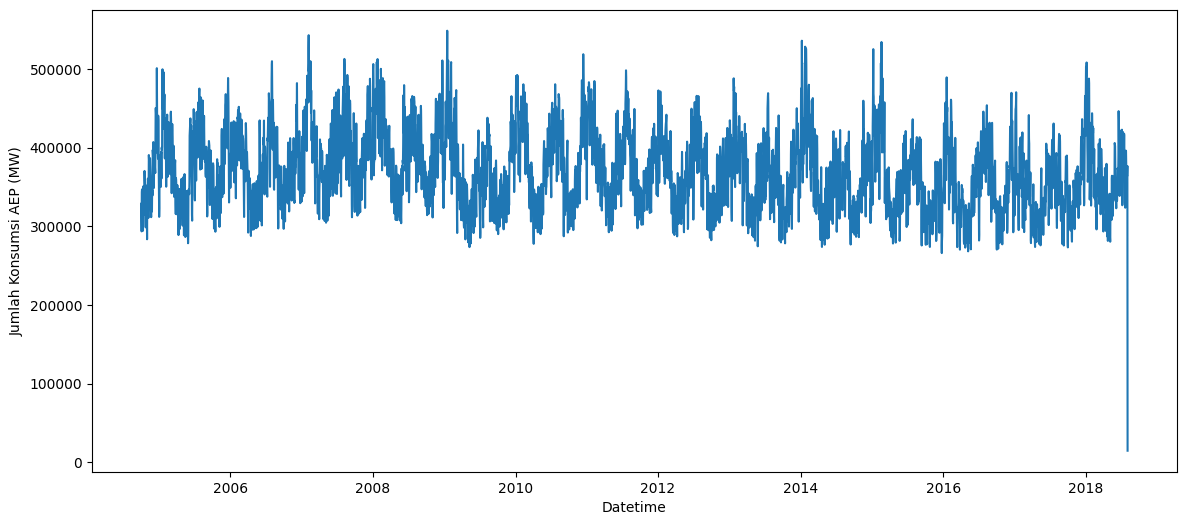

In [162]:
# Melihat pattern data
import matplotlib.pyplot as plt
import seaborn as sns 

fig, axes = plt.subplots(figsize=(14, 6))
sns.lineplot(data=df_daily, x=df_daily.index, y='AEP_MW')
plt.ylabel('Jumlah Konsumsi AEP (MW)')

plt.show()

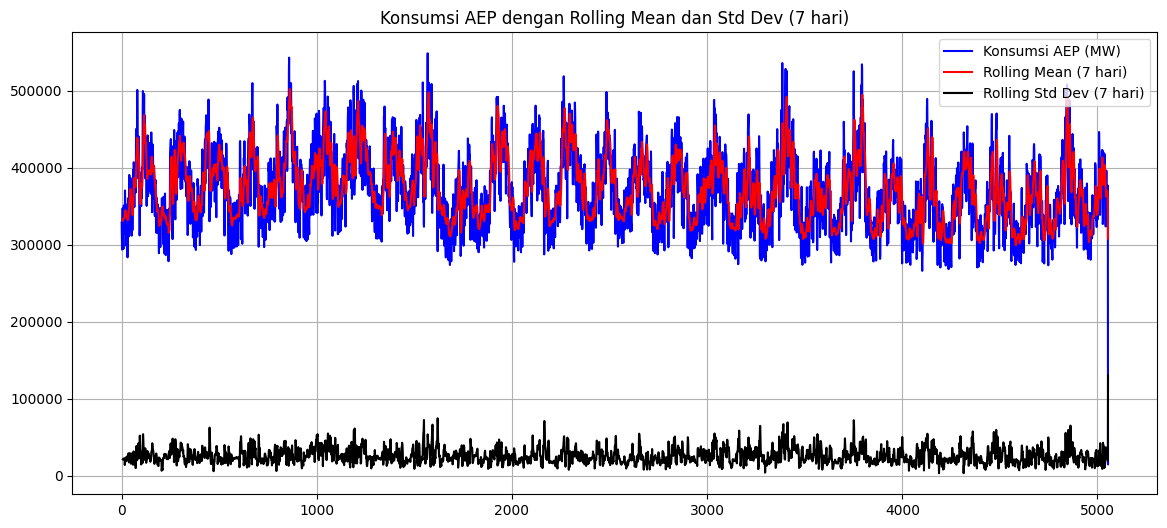

In [85]:
rolling_mean = df_daily['AEP_MW'].rolling(7).mean()
rolling_std = df_daily['AEP_MW'].rolling(7).std()

plt.figure(figsize=(14,6))
plt.plot(df_daily['AEP_MW'], color="blue", label="Konsumsi AEP (MW)")
plt.plot(rolling_mean, color="red", label="Rolling Mean (7 hari)")
plt.plot(rolling_std, color="black", label="Rolling Std Dev (7 hari)")
plt.title("Konsumsi AEP dengan Rolling Mean dan Std Dev (7 hari)")
plt.legend()
plt.grid(True)
plt.show()


In [87]:
# Adfuller Test
adft = adfuller(df_daily['AEP_MW'], autolag="AIC")

adft_df = pd.DataFrame({
    'Values': [
        adft[0],     # Test Statistic
        adft[1],     # p-value
        adft[2],     # number of lags used
        adft[3],     # number of observations used
        adft[4]['1%'],  # critical value 1%
        adft[4]['5%'],  # critical value 5%
        adft[4]['10%']  # critical value 10%
    ],
    'Metric': [
        'Test Statistic', 'p-value', 'No. of Lags Used', 'Number of Observations Used',
        'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'
    ]
})

print(adft_df)

         Values                       Metric
0 -7.279596e+00               Test Statistic
1  1.512584e-10                      p-value
2  3.000000e+01             No. of Lags Used
3  5.024000e+03  Number of Observations Used
4 -3.431652e+00          Critical Value (1%)
5 -2.862115e+00          Critical Value (5%)
6 -2.567076e+00         Critical Value (10%)


In [92]:
# Autocorrelation
lags = [1,3,6,9]

for lag in lags:
    autocorrelation_lag = df_daily['AEP_MW'].autocorr(lag=lag)
    print(autocorrelation_lag)

0.8433059615133761
0.5583553461707099
0.5972197778927197
0.4568344411830876


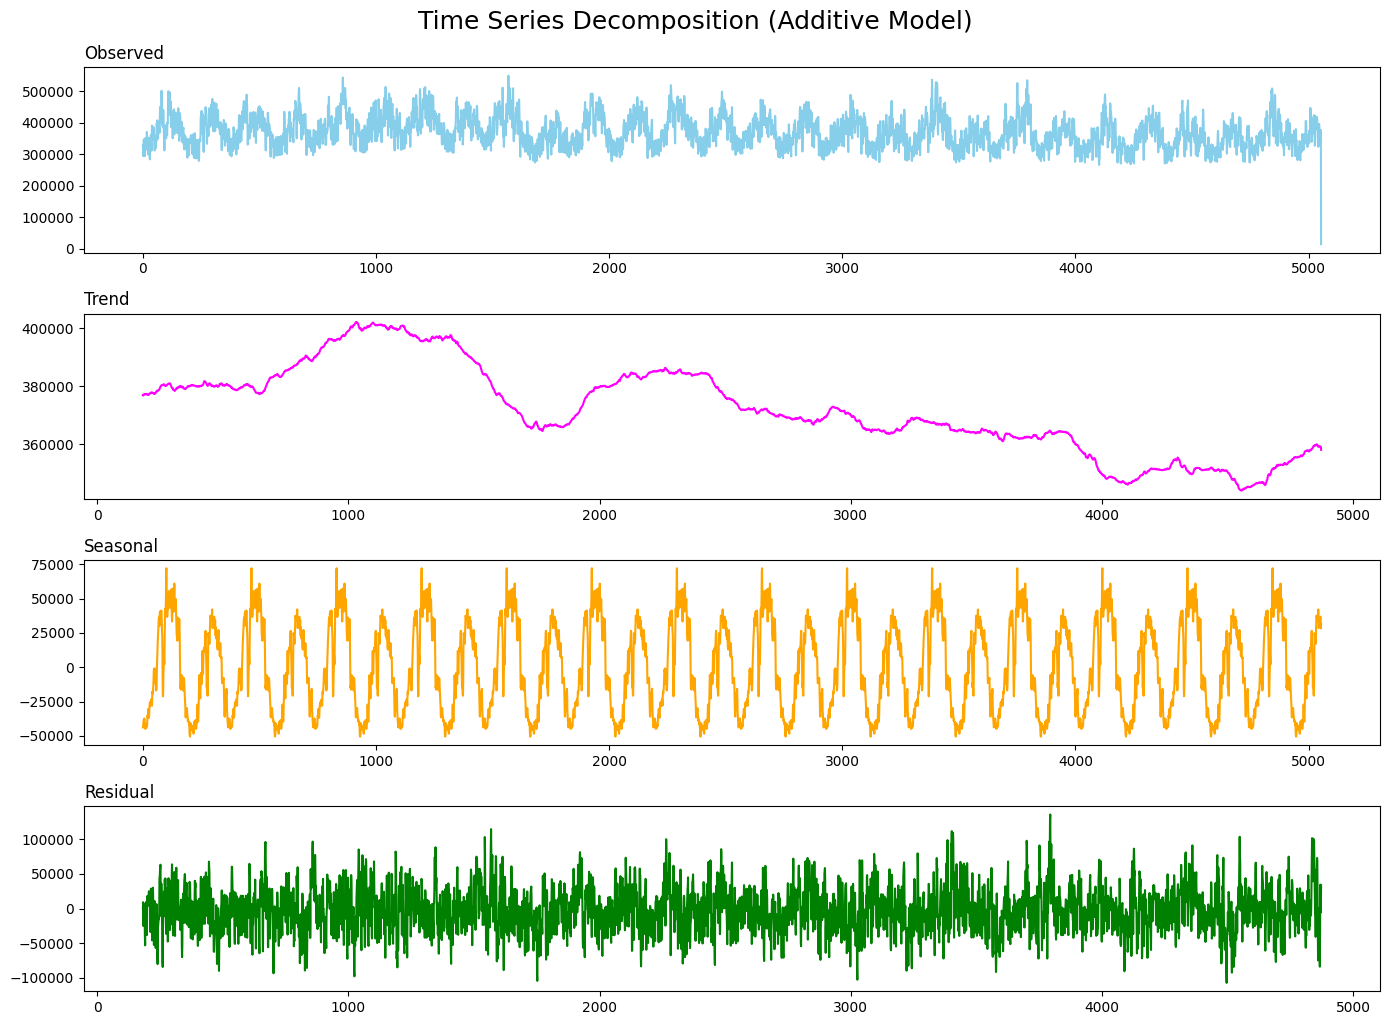

In [102]:
# 3. Lakukan dekomposisi (asumsi musiman tahunan)
decompose = seasonal_decompose(df_daily['AEP_MW'], model='additive', period=365)

# 4. Plot komponen satu per satu dengan warna berbeda dan judul di kiri
plt.figure(figsize=(14, 10))

# Observed (data asli)
plt.subplot(411)
plt.plot(decompose.observed, label='Observed', color='skyblue')
plt.title('Observed', loc='left')

# Trend
plt.subplot(412)
plt.plot(decompose.trend, label='Trend', color='magenta')
plt.title('Trend', loc='left')

# Seasonal
plt.subplot(413)
plt.plot(decompose.seasonal, label='Seasonal', color='orange')
plt.title('Seasonal', loc='left')

# Residual
plt.subplot(414)
plt.plot(decompose.resid, label='Residual', color='green')
plt.title('Residual', loc='left')

# Tambahan layout
plt.tight_layout()
plt.suptitle("Time Series Decomposition (Additive Model)", fontsize=18, y=1.02)
plt.show()

C:\Users\71478\AppData\Local\Temp\ipykernel_19064\3799885599.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['AEP_MW']
C:\Users\71478\AppData\Local\Temp\ipykernel_19064\3799885599.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['AEP_MW']


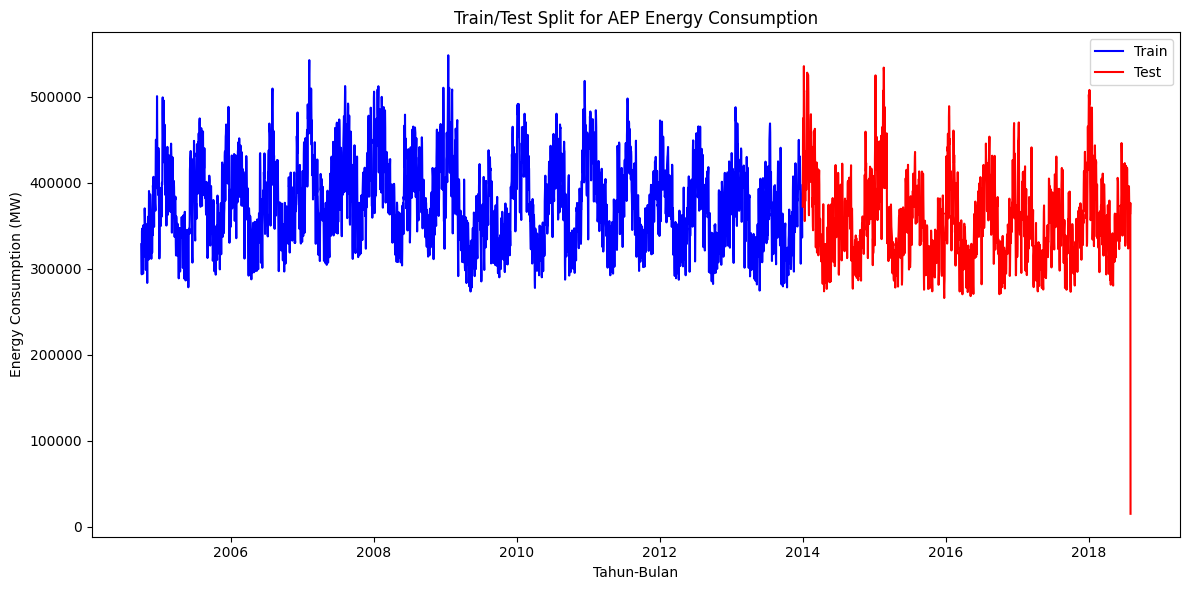

In [148]:
# Tambahkan kolom tanggal agar bisa digunakan untuk filter
df_daily['Date'] = df_daily.index

# Split data: train < 2014-01, test >= 2014-01
train = df_daily[df_daily['Date'] < pd.to_datetime("2014-01", format='%Y-%m')]
train['train'] = train['AEP_MW']
del train['Date']
del train['AEP_MW']

test = df_daily[df_daily['Date'] >= pd.to_datetime("2014-01", format='%Y-%m')]
test['test'] = test['AEP_MW']
del test['Date']
del test['AEP_MW']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['train'], color="blue", label="Train")
plt.plot(test.index, test['test'], color="red", label="Test")
plt.title("Train/Test Split for AEP Energy Consumption")
plt.ylabel("Energy Consumption (MW)")
plt.xlabel("Tahun-Bulan")
plt.legend()
plt.tight_layout()
plt.show()

In [153]:
# Prediksi sepanjang test set
forecast = model_fit.forecast(steps=len(test))

# Hitung RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print("RMSE ARIMA:", rmse)
print(f"Persentase Error: {(rmse / df_daily['AEP_MW'].mean()) * 100:.2f}% dari rata-rata konsumsi harian")

RMSE ARIMA: 51006.955035930354
Persentase Error: 13.72% dari rata-rata konsumsi harian


In [150]:
print(test.describe())

                test
count    1676.000000
mean   357036.097852
std     47213.955901
min     14809.000000
25%    322385.500000
50%    350797.500000
75%    387704.750000
max    535660.000000


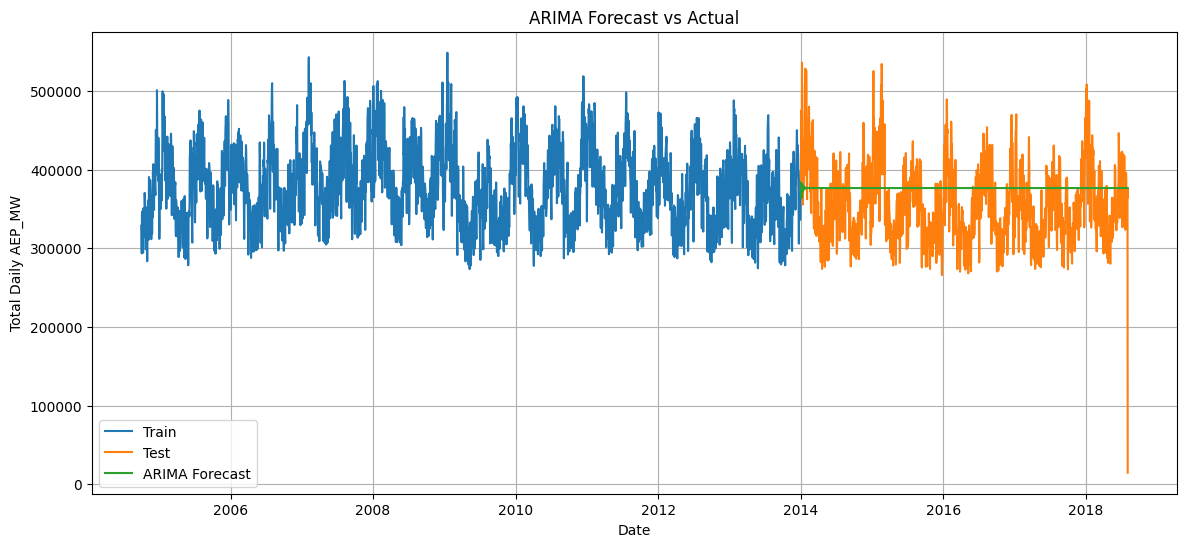

In [151]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Total Daily AEP_MW')
plt.legend()
plt.grid(True)
plt.show()


##### Linear Regression

In [69]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [70]:
# Baca dan urutkan data
df = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'])
df = df.sort_values('Datetime')
df.set_index('Datetime', inplace=True)

In [71]:
# Ubah data menjadi harian (penjumlahan per hari)
df_daily = df.resample('D').sum()

In [72]:
# Reset index agar kolom datetime bisa digunakan
df_daily = df_daily.reset_index()

In [73]:
# Buat kolom fitur waktu numerik
df_daily['Time_Num'] = df_daily['Datetime'].map(pd.Timestamp.toordinal)

In [74]:
# Split train-test berdasarkan tanggal
train = df_daily[df_daily['Datetime'] < '2014-01-01']
test = df_daily[df_daily['Datetime'] >= '2014-01-01']

In [75]:
# Buat dan latih model
lr = LinearRegression()
lr.fit(train[['Time_Num']], train['AEP_MW'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [76]:
# Prediksi pada test set
predictions = lr.predict(test[['Time_Num']])

In [77]:
rmse = sqrt(mean_squared_error(test['AEP_MW'], predictions))
print("RMSE Linear Regression:", rmse)

RMSE Linear Regression: 47565.03853277265


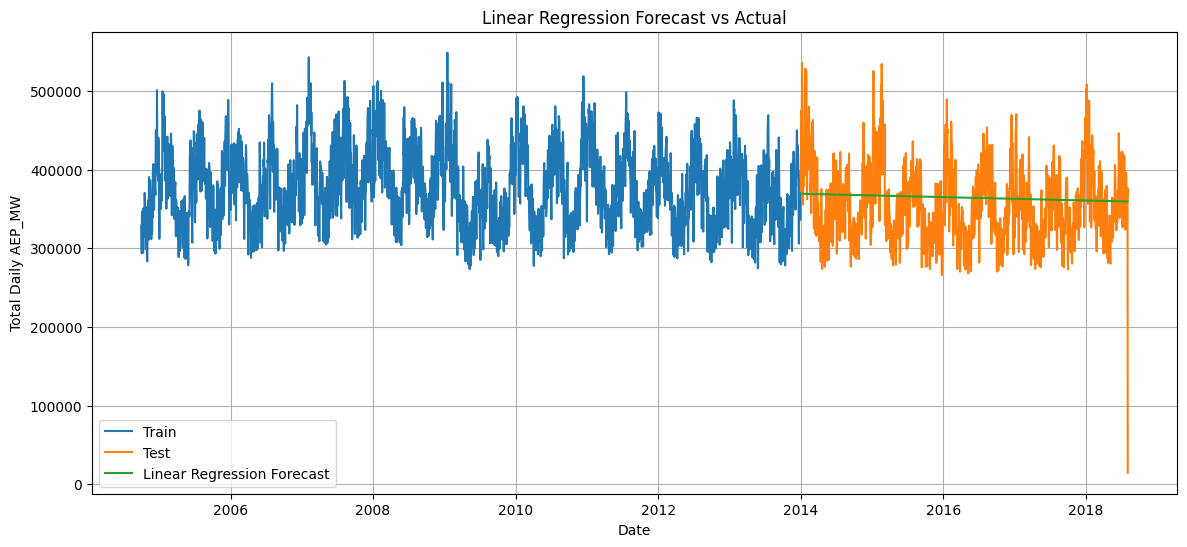

In [78]:
plt.figure(figsize=(14,6))
plt.plot(train['Datetime'], train['AEP_MW'], label='Train')
plt.plot(test['Datetime'], test['AEP_MW'], label='Test')
plt.plot(test['Datetime'], predictions, label='Linear Regression Forecast')
plt.xlabel('Date')
plt.ylabel('Total Daily AEP_MW')
plt.title('Linear Regression Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()